# 导入需要使用的包，指定文件路径和图片类型 | Import the necessary packages and specify the file path and image type to be used

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import sys

file_path = "D:\EOSR7"
file_type_a = ".jpg", ".jpeg", ".png"
file_type_A = tuple(map(str.upper, file_type_a))

print(file_type_a, file_type_A)

('.jpg', '.jpeg', '.png') ('.JPG', '.JPEG', '.PNG')


# 读取所有目录下的图片文件 | Read all image files in the directory

In [148]:
# define a list to store the image's file pathes, including the subfolders
jpg_path_list = []
TOTAL_SIZE = 0
for root, dirs, files in os.walk(file_path):
    for file in files:
        if file.endswith(file_type_A) or file.endswith(file_type_a):
            jpg_path_list.append(os.path.join(root, file))
# print the size of the list
TOTAL_SIZE = len(jpg_path_list)
print("The number of the image file is: ", TOTAL_SIZE)
print(jpg_path_list[0:5])

The number of the image file is:  5314
['D:\\EOSR7\\Avatar.png', 'D:\\EOSR7\\IMG_2008.JPG', 'D:\\EOSR7\\IMG_2009.JPG', 'D:\\EOSR7\\IMG_2010.JPG', 'D:\\EOSR7\\IMG_2012.JPG']


# 定义需要使用的方法 | Define the methods to be used

In [149]:
def get_focal_length(image_path):
    """
    Get the focal length of the image.
    :param image_path: the path of the image
    :return: the focal length of the image
    """
    try:
        focal_length = Image.open(image_path)._getexif()[37386]
    except:
        PrintErrorImage(image_path)
        return

    return focal_length


def get_F_stop(image_path):
    """
    Get the F-stop of the image.
    :param image_path: the path of the image
    :return: the F-stop of the image
    """
    try:
        F_stop = Image.open(image_path)._getexif()[33437]
    except:
        PrintErrorImage(image_path)
        return
    return F_stop


def get_ISO(image_path):
    """
    Get the ISO of the image.
    :param image_path: the path of the image
    :return: the ISO of the image
    """
    try:
        ISO = Image.open(image_path)._getexif()[34855]
    except:
        PrintErrorImage(image_path)
        return
    return ISO


def get_shutter_speed(image_path):
    """
    Get the shutter speed of the image.
    :param image_path: the path of the image
    :return: the shutter speed of the image
    """
    try:
        shutter_speed = Image.open(image_path)._getexif()[33434]
    except:
        PrintErrorImage(image_path)
        return
    return shutter_speed


def PrintErrorImage(image_path):
    print(
        "Error image: ",
        image_path,
        "may not have focal length, F-stop, ISO, or shutter speed",
    )


def print_progress(progressName, current, total):
    """
    PRINT THE PROGRESS OF THE PROCESS
    :param current: the current number of the process
    :param total: the total number of the process
    """
    progress = current / total
    # print % without 0
    sys.stdout.write(
        "\r"
        + progressName
        + " Progress: [{0:50s}] {1:.1f}%".format(
            "=" * int(progress * 50), progress * 100
        )
    )
    sys.stdout.flush()

# 读取图片信息并存储到pandas的DataFrame中

In [150]:
# 提取快门速度、ISO值、焦距、光圈值的关系
shutter_speed_list = []
ISO_list = []
focal_length_list = []
F_stop_list = []
for jpg_path in jpg_path_list:
    shutter_speed = get_shutter_speed(jpg_path)
    ISO = get_ISO(jpg_path)
    focal_length = get_focal_length(jpg_path)
    F_stop = get_F_stop(jpg_path)

    shutter_speed_list.append(shutter_speed)
    ISO_list.append(ISO)
    focal_length_list.append(focal_length)
    F_stop_list.append(F_stop)
    print_progress("Reading Images", len(shutter_speed_list), len(jpg_path_list))

Error image:  D:\EOSR7\Avatar.png may not have focal length, F-stop, ISO, or shutter speed
Error image:  D:\EOSR7\Avatar.png may not have focal length, F-stop, ISO, or shutter speed
Error image:  D:\EOSR7\Avatar.png may not have focal length, F-stop, ISO, or shutter speed
Error image:  D:\EOSR7\Avatar.png may not have focal length, F-stop, ISO, or shutter speed
Reading Images Progress: [==================================================] 100.0%

In [151]:
# 将数据存储到pandas中, index 为jpg_path_list
data = {
    "shutter_speed(s)": shutter_speed_list,
    "ISO": ISO_list,
    "focal_length(mm)": focal_length_list,
    "F_stop(/f)": F_stop_list,
}
images_df = pd.DataFrame(data, index=jpg_path_list)
images_df

,shutter_speed(s),ISO,focal_length(mm),F_stop(/f)
D:\EOSR7\Avatar.png,None,NaN,None,None
D:\EOSR7\IMG_2008.JPG,0.0015625,1250.0,149.0,6.3
D:\EOSR7\IMG_2009.JPG,0.0015625,1000.0,149.0,6.3
D:\EOSR7\IMG_2010.JPG,0.0015625,1250.0,149.0,6.3
D:\EOSR7\IMG_2012.JPG,0.0015625,1600.0,141.0,6.3
...,...,...,...,...
D:\EOSR7\2023-9-BackHome\IMG_1339.JPG,0.00625,5000.0,45.0,5.6
D:\EOSR7\2023-9-BackHome\IMG_1340.JPG,0.00625,6400.0,50.0,5.6
D:\EOSR7\2023-9-BackHome\IMG_1341.JPG,0.00625,3200.0,45.0,5.6
D:\EOSR7\2023-9-BackHome\IMG_1343.JPG,0.016666666666666666,800.0,18.0,3.5


# 搜索目录内图片名称来确保图片是否被正确读取 | Search the directory for image names to ensure that the images are read correctly


In [152]:
target_image_path = "IMG_1339.JPG"
for index in images_df.index:
    if index.endswith(target_image_path):
        print(target_image_path + " was found at index: ", index)

IMG_1339.JPG was found at index:  D:\EOSR7\2023-9-BackHome\IMG_1339.JPG


# 分析图片的焦距（如果你有一个变焦镜头的话） | Analyze the focal length of the image (if you have a zoom lens)

In [153]:
# 定义一个焦段字典，以焦段为键，以数量为值: 8-15,16-24,25-35,35-50,50-70,70-105,105-135,135-200,200-300,300-400,400-600,600-800,800-1200,1200-1600,1600-2000
focal_length_dict = {
    "8-15 ": 0,
    "16-24": 0,
    "24-35": 0,
    "35-50": 0,
    "50-70": 0,
    "70-105": 0,
    "105-135": 0,
    "135-200": 0,
    "200-300": 0,
    "300-400": 0,
    "400-600": 0,
    "600-800": 0,
    "800-1200": 0,
    "1200-1600": 0,
    "1600-2000": 0,
}


def count_focal_length(df, dict):
    progress = 0
    invalid_count = 0
    # get all
    for index, row in df.iterrows():
        focal_length = row["focal_length(mm)"]
        if focal_length is None:
            invalid_count += 1
            print("Invalid focal length", index)
            continue
        if focal_length < 15:
            dict["8-15 "] += 1
        elif focal_length < 25:
            dict["16-24"] += 1
        elif focal_length < 35:
            dict["24-35"] += 1
        elif focal_length < 50:
            dict["35-50"] += 1
        elif focal_length < 70:
            dict["50-70"] += 1
        elif focal_length < 105:
            dict["70-105"] += 1
        elif focal_length < 135:
            dict["105-135"] += 1
        elif focal_length < 200:
            dict["135-200"] += 1
        elif focal_length < 300:
            dict["200-300"] += 1
        elif focal_length < 400:
            dict["300-400"] += 1
        elif focal_length < 600:
            dict["400-600"] += 1
        elif focal_length < 800:
            dict["600-800"] += 1
        elif focal_length < 1200:
            dict["800-1200"] += 1
        elif focal_length < 1600:
            dict["1200-1600"] += 1
        elif focal_length < 2000:
            dict["1600-2000"] += 1
        progress += 1
        print_progress("Counting Focal Length", progress, len(df))
    return invalid_count


invalid_count = count_focal_length(images_df, focal_length_dict)
print(" Invalid focal length count: ", invalid_count)
focal_length_dict

Invalid focal length D:\EOSR7\Avatar.png
Counting Focal Length Progress: [================================================= ] 100.0% Invalid focal length count:  1


{'8-15 ': 23,
 '16-24': 715,
 '24-35': 258,
 '35-50': 618,
 '50-70': 650,
 '70-105': 1252,
 '105-135': 348,
 '135-200': 991,
 '200-300': 156,
 '300-400': 102,
 '400-600': 200,
 '600-800': 0,
 '800-1200': 0,
 '1200-1600': 0,
 '1600-2000': 0}

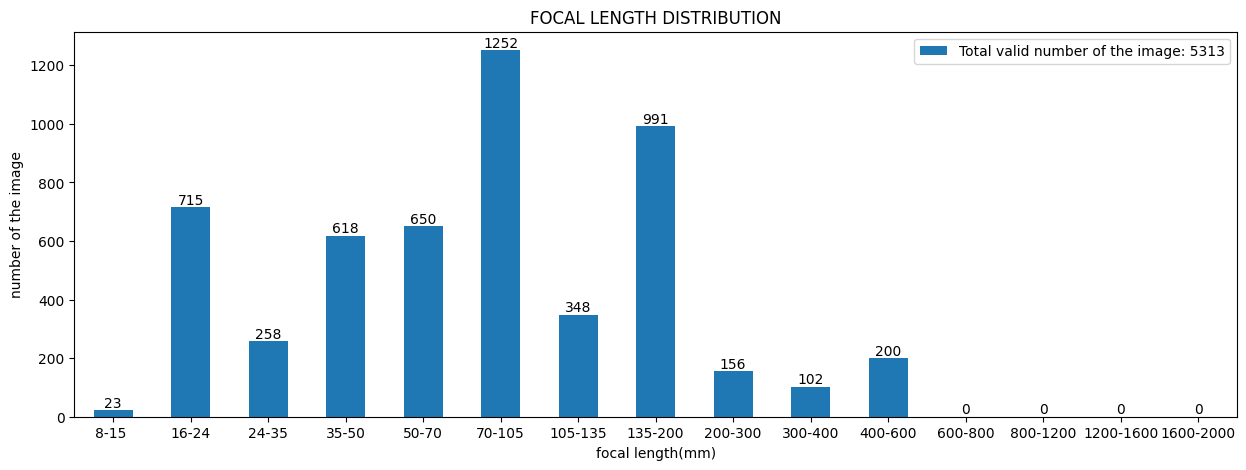

In [154]:
# 以柱状图的形式展示焦段字典，plot标题为照片总数，y轴为焦段，x轴为照片数量，并在每个柱状图上显示照片数量
plt.figure(figsize=(15, 5))
focal_length_series = pd.Series(focal_length_dict)
focal_length_series.plot(kind="bar", title=str.upper("focal length distribution"))
for x, y in enumerate(focal_length_series):
    plt.text(x, y, "%s" % y, ha="center", va="bottom")
plt.legend(["Total valid number of the image: " + str(TOTAL_SIZE - invalid_count)])
plt.xticks(rotation=0)
plt.xlabel("focal length(mm)")
plt.ylabel("number of the image")
plt.show(block=False)

以上统计结果可以一定程度上反映出自己喜欢的焦段（前提是你有一个变焦镜头），可以帮助自己更好的选择镜头。

## 汇合常用焦段

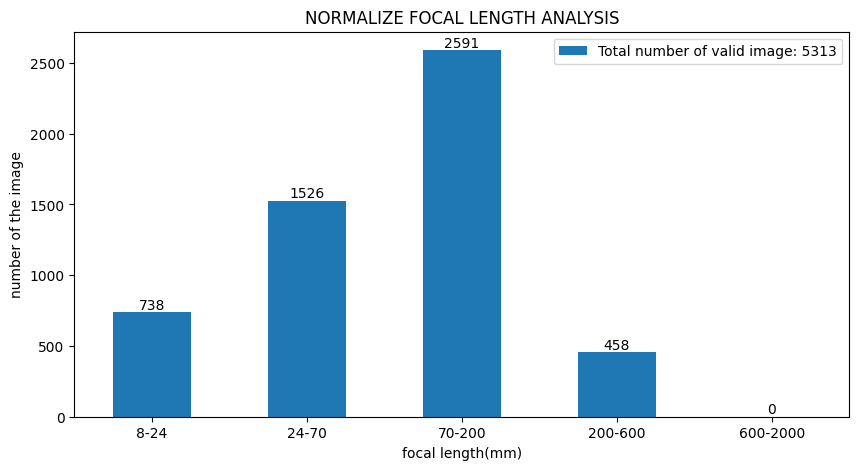

In [155]:
# 自定义一个常用焦距区间dict，以焦距区间为键，以数量为值
focal_length_dict_Normal = {
    "8-24": 0,
    "24-70": 0,
    "70-200": 0,
    "200-600": 0,
    "600-2000": 0,
}
# 遍历先前的焦段字典，将焦段数量累加到常用焦距区间字典中
for key, value in focal_length_dict.items():
    if key == "8-15 " or key == "16-24":
        focal_length_dict_Normal["8-24"] += value
    elif key == "24-35" or key == "35-50" or key == "50-70":
        focal_length_dict_Normal["24-70"] += value
    elif key == "70-105" or key == "105-135" or key == "135-200":
        focal_length_dict_Normal["70-200"] += value
    elif key == "200-300" or key == "300-400" or key == "400-600":
        focal_length_dict_Normal["200-600"] += value
    elif (
        key == "600-800"
        or key == "800-1200"
        or key == "1200-1600"
        or key == "1600-2000"
    ):
        focal_length_dict_Normal["600-2000"] += value
# 以柱状图的形式展示焦距区间字典，plot标题为照片总数，y轴为焦距区间，x轴为照片数量，并在每个柱状图上显示照片数量
plt.figure(figsize=(10, 5))

focal_length_series_custom = pd.Series(focal_length_dict_Normal)
focal_length_series_custom.plot(
    kind="bar", title=str.upper("Normalize focal length analysis")
)
for x, y in enumerate(focal_length_series_custom):
    plt.text(x, y, "%s" % y, ha="center", va="bottom")
plt.xticks(rotation=0)
plt.legend(["Total number of valid image: " + str(TOTAL_SIZE - invalid_count)])
plt.xlabel("focal length(mm)")
plt.ylabel("number of the image")
plt.show(block=False)

# 分析图片的光圈

In [156]:
# 统计光圈值，遍历images_df,获取每张图片的光圈值,如果光圈值不在字典中，则将其添加到字典中
F_stop_dict = {}


def count_F_stop(df, dict):
    progress = 0
    invalid_count = 0
    for index, row in df.iterrows():
        if row["F_stop(/f)"] is None:
            print("Invalid F-stop", index)
            invalid_count += 1
            continue
        F_stop = row["F_stop(/f)"]
        if F_stop not in dict:
            dict[F_stop] = 1
        else:
            dict[F_stop] += 1
        progress += 1
        print_progress("Counting F-stop", progress, len(df))
    return dict, invalid_count


invalid_count = count_F_stop(images_df, F_stop_dict)[1]
# 根据F_stop_dict 的键排序，以便于后续画图
F_stop_dict = dict(sorted(F_stop_dict.items()))

Invalid F-stop D:\EOSR7\Avatar.png
Counting F-stop Progress: [================================================= ] 100.0%

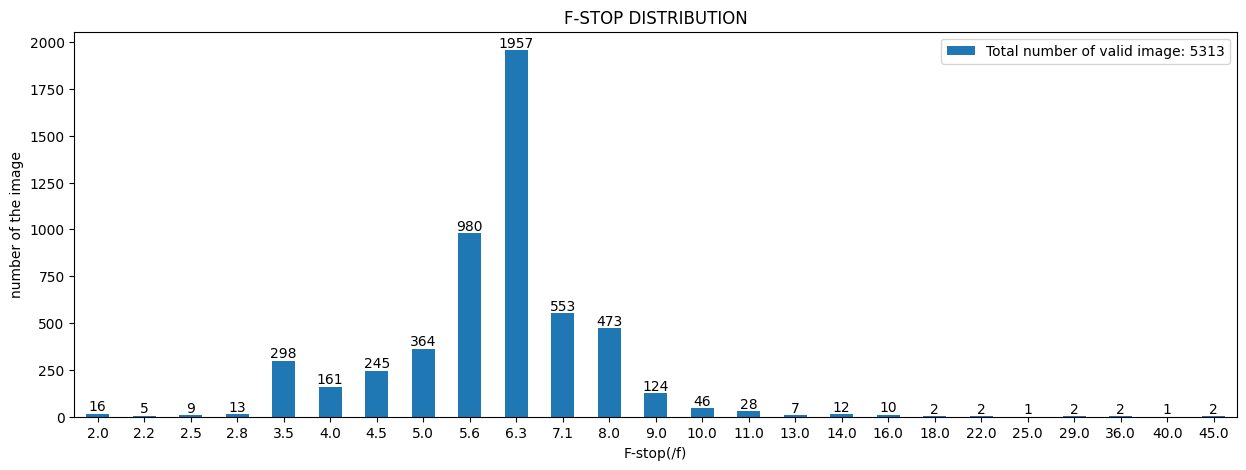

In [157]:
# 以柱状图的形式展示光圈值字典，plot标题为照片总数，y轴为光圈值，x轴为照片数量，并在每个柱状图上显示照片数量
plt.figure(figsize=(15, 5))
F_stop_series = pd.Series(F_stop_dict)
F_stop_series.plot(kind="bar", title=str.upper("F-stop distribution"))
for x, y in enumerate(F_stop_series):
    plt.text(x, y, "%s" % y, ha="center", va="bottom")
plt.xlabel("F-stop(/f)")
plt.ylabel("number of the image")
plt.legend(["Total number of valid image: " + str(TOTAL_SIZE - invalid_count)])
plt.xticks(rotation=0)
plt.show(block=False)

# 分析图片的快门速度？

In [158]:
# To be continued??

# 快门速度、光圈、焦距之间的关系？| Relationship between shutter speed, aperture, and focal length?

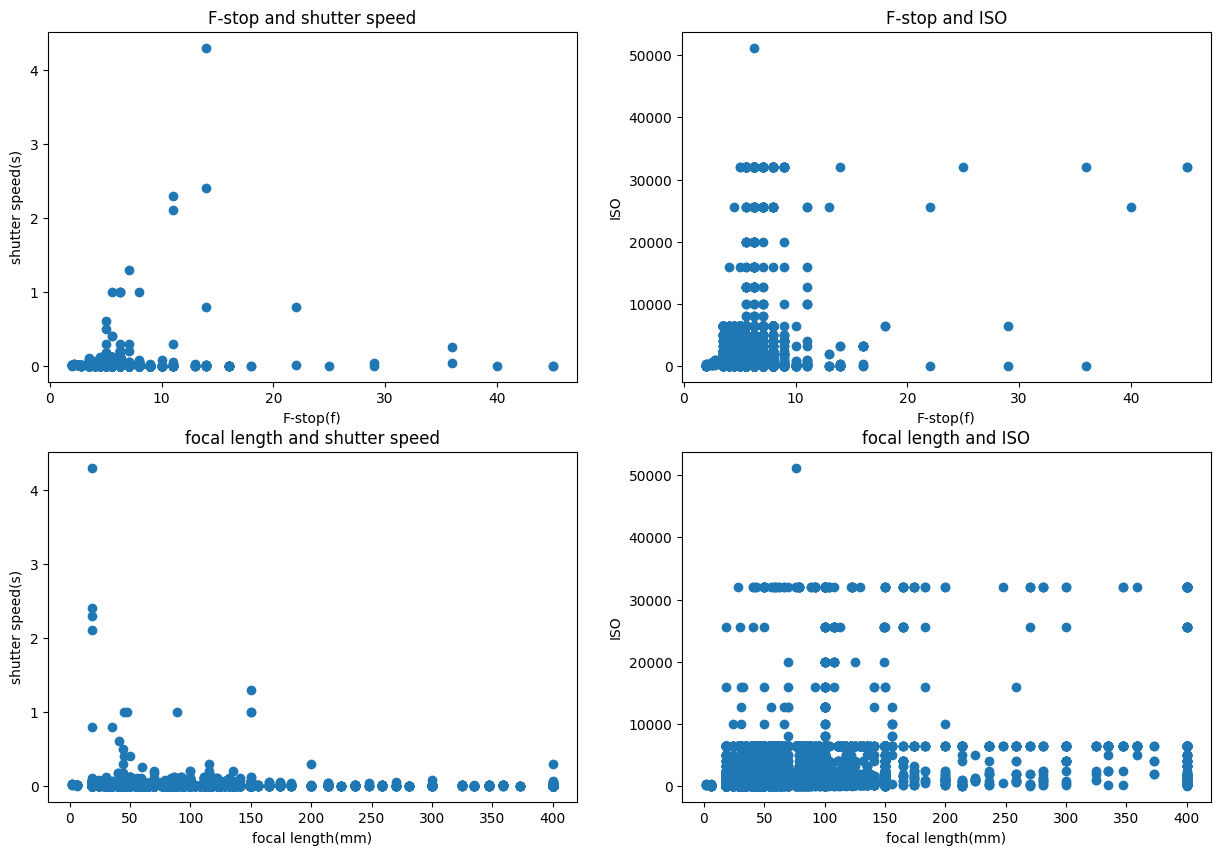

In [159]:
# 以光圈值为y轴，快门速度为x轴，绘制散点图; 以光圈值为x轴，ISO值为y轴，绘制散点图; 以焦距为x轴，快门速度为y轴，绘制散点图; 以焦距为x轴，ISO值为y轴，绘制散点图;
# draw the scatter plot of the relationship between F-stop and shutter speed, F-stop and ISO, focal length and shutter speed, focal length and ISO
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.scatter(F_stop_list, shutter_speed_list)
plt.title("F-stop and shutter speed")
plt.xlabel("F-stop(f)")
plt.ylabel("shutter speed(s)")

plt.subplot(2, 2, 2)
plt.scatter(F_stop_list, ISO_list)
plt.title("F-stop and ISO")
plt.xlabel("F-stop(f)")
plt.ylabel("ISO")
plt.subplot(2, 2, 3)
plt.scatter(focal_length_list, shutter_speed_list)
plt.title("focal length and shutter speed")
plt.xlabel("focal length(mm)")
plt.ylabel("shutter speed(s)")

plt.subplot(2, 2, 4)
plt.scatter(focal_length_list, ISO_list)
plt.title("focal length and ISO")
plt.xlabel("focal length(mm)")
plt.ylabel("ISO")
plt.show(block=False)

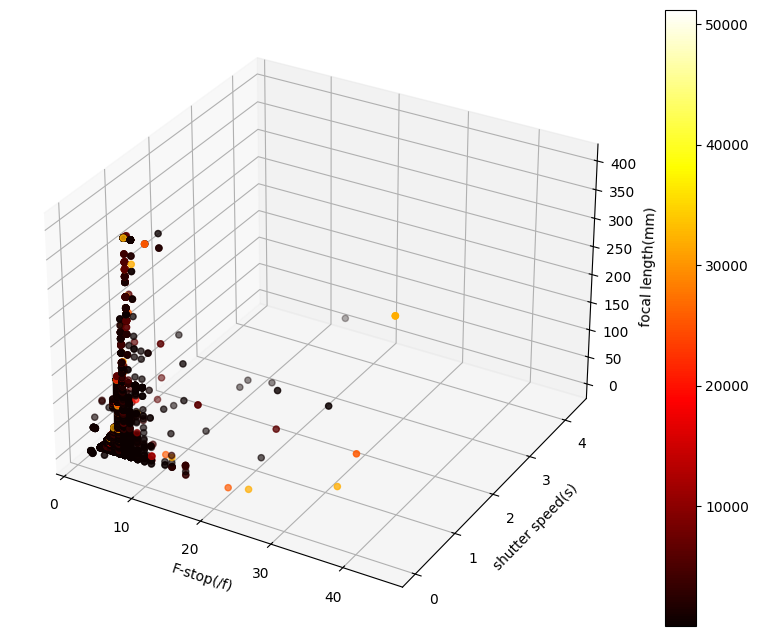

,shutter_speed(s),ISO,focal_length(mm),F_stop(/f)
D:\EOSR7\IMG_2008.JPG,0.0015625,1250.0,149.0,6.3
D:\EOSR7\IMG_2009.JPG,0.0015625,1000.0,149.0,6.3
D:\EOSR7\IMG_2010.JPG,0.0015625,1250.0,149.0,6.3
D:\EOSR7\IMG_2012.JPG,0.0015625,1600.0,141.0,6.3
D:\EOSR7\IMG_2013.JPG,0.0015625,1600.0,141.0,6.3
...,...,...,...,...
D:\EOSR7\2023-9-BackHome\IMG_1339.JPG,0.00625,5000.0,45.0,5.6
D:\EOSR7\2023-9-BackHome\IMG_1340.JPG,0.00625,6400.0,50.0,5.6
D:\EOSR7\2023-9-BackHome\IMG_1341.JPG,0.00625,3200.0,45.0,5.6
D:\EOSR7\2023-9-BackHome\IMG_1343.JPG,0.016666666666666666,800.0,18.0,3.5


In [160]:
# 以光圈值为x轴，快门速度为y轴，焦距为z轴，ISO值为颜色（值越大透明度越低）绘制3D散点图
# draw the 3D scatter plot of the relationship between F-stop, shutter speed, focal length and ISO

# remove the invalid data
images_df = images_df.dropna()

fig = plt.figure()
# size of the figure
fig.set_size_inches(10, 8)
ax = fig.add_subplot(111, projection="3d")
x = images_df["F_stop(/f)"]
y = images_df["shutter_speed(s)"]
z = images_df["focal_length(mm)"]
c = images_df["ISO"]
img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
ax.set_xlabel("F-stop(/f)")
ax.set_ylabel("shutter speed(s)")
ax.set_zlabel("focal length(mm)")
plt.show()
images_df